## Confirm Py6S installation

In [10]:
from Py6S import *
SixS.test()


6S wrapper script by Robin Wilson
Using 6S located at /usr/local/bin/sixsV1.1
Running 6S using a set of test parameters
6sV version: 1.1
The results are:
Expected result: 619.158000
Actual result: 619.158000
#### Results agree, Py6S is working correctly


0

Running for many wavelengths - this may take a long time


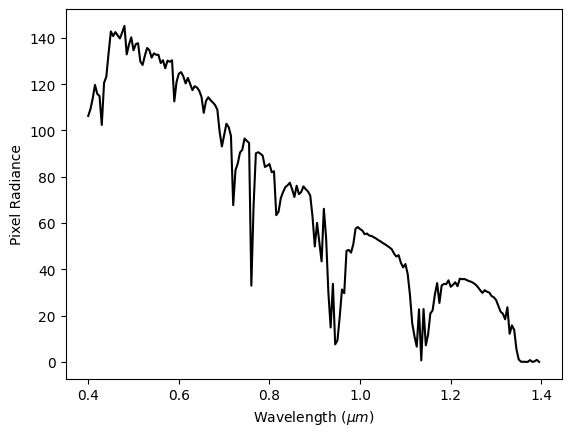

In [3]:
# Create a SixS object called s (used as the standard name by convention)
s = SixS()
# Run the 6S simulation defined by this SixS object across the
# whole VNIR range
wavelengths, results = SixSHelpers.Wavelengths.run_vnir(s, output_name="pixel_radiance")
# Plot these results, with the y axis label set to "Pixel Radiance"
SixSHelpers.Wavelengths.plot_wavelengths(wavelengths, results, "Pixel Radiance")

## Calculate maximum solar energy

In [1]:
import os
import random
import logging
import pytz
import math
import requests
import time
import pickle
import rasterio
import elevation

import richdem as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Py6S import *
from io import StringIO
from datetime import datetime, timedelta
from timezonefinder import TimezoneFinder

In [2]:
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

#### Create 1x1 deg grid of all-sky DNI for swath of N. Atlantic for S23

In [ ]:
# Get estimated all-sky DNI from NASA POWER API for swath of N. Atlantic for Summer 2022 (1 deg x 1 deg)
def fetch_data(latitude, longitude): 
    url = f"https://power.larc.nasa.gov/api/temporal/hourly/point?start=20220320&end=20220924&latitude={latitude}&longitude={longitude}&community=sb&parameters=ALLSKY_SFC_SW_DNI&format=csv&header=true&time-standard=utc"
    response = requests.get(url, headers={"accept": "application/json"})
    if response.status_code == 200:
        data = response.content.decode('utf-8')

        # Find the end of the header
        end_of_header = data.find("-END HEADER-") + len("-END HEADER-\n")
        data_no_header = data[end_of_header:]

        try:
            df = pd.read_csv(StringIO(data_no_header))
            return df
        except Exception as e:
            print(f"Error parsing data for latitude {latitude} and longitude {longitude}: {e}")
            return pd.DataFrame()
    else:
        print(f"Failed to fetch data for latitude {latitude} and longitude {longitude}")
        return pd.DataFrame()


In [ ]:
all_data = pd.DataFrame()

for lon in range(-20, -51, -1):  # Step is -1 because we're moving from east to west
    for lat in range(61):
        df = fetch_data(lat, lon)
        if not df.empty:
            df['lat'] = lat  
            df['lon'] = lon 
            all_data = pd.concat([all_data, df], ignore_index=True)
    logging.info(f"Processed all latitudes for longitude {lon}")
    time.sleep(120)

# all_data.to_csv("/Users/timothydonohue/Downloads/nasa_power_data.csv", index=False)

In [15]:
df = pd.read_csv('/Users/timothydonohue/Documents/Data/nasa_power_data.csv')
df.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DNI,lat,lon
0,2022,3,20,0,0.0,0,-20
1,2022,3,20,1,0.0,0,-20
2,2022,3,20,2,0.0,0,-20
3,2022,3,20,3,0.0,0,-20
4,2022,3,20,4,0.0,0,-20


In [48]:
print(df.dtypes)
df.shape

year           int64
month          int64
day            int64
hour           int64
sfc_dni      float64
lat          float64
lon          float64
timestamp      int64
dtype: object


(8577576, 8)

In [16]:
df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}, inplace=True)
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], utc=True)
df['timestamp'] = df['timestamp'].apply(lambda x: int(x.timestamp()))

df = df.drop(['year', 'month', 'day', 'hour'], axis=1)

# convert lat and lon columns to float
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

df.rename(columns={'ALLSKY_SFC_SW_DNI': 'sfc_dni'}, inplace=True)
df

,sfc_dni,lat,lon,timestamp
0,0.00,0.0,-20.0,1647734400
1,0.00,0.0,-20.0,1647738000
2,0.00,0.0,-20.0,1647741600
3,0.00,0.0,-20.0,1647745200
4,0.00,0.0,-20.0,1647748800
...,...,...,...,...
8577571,40.14,60.0,-50.0,1664046000
8577572,34.61,60.0,-50.0,1664049600
8577573,0.00,60.0,-50.0,1664053200
8577574,0.00,60.0,-50.0,1664056800


In [17]:
data_dict = {
    lat: {
        lon: group.set_index('timestamp')['sfc_dni'].apply(
            lambda x: {'sfc_dni': x}
        ).to_dict()
        for lon, group in lat_group.groupby('lon')
    }
    for lat, lat_group in df.groupby('lat')
}

output_path = '/Users/timothydonohue/Documents/Aerology Repos/uav-carbon-removal/nasa_power_dict.pkl'
with open(output_path, 'wb') as pickle_file:
    pickle.dump(data_dict, pickle_file)

In [63]:
def print_dict_head(data_dict, num_entries=5):
    count = 0
    for lat, lon_dict in data_dict.items():
        for lon, timestamp_dict in lon_dict.items():
            for timestamp, values in timestamp_dict.items():
                print(f"Lat: {lat}, Lon: {lon}, Timestamp: {timestamp}, Values: {values}")
                count += 1
                if count >= num_entries:
                    return

# Example usage
print_dict_head(data_dict, 6)


Lat: 0.0, Lon: -50.0, Timestamp: 1647734400, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647738000, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647741600, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647745200, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647748800, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647752400, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}


In [5]:
# Access the sfc_dni value
sfc_dni_value = data_dict[0][-50.0][1647752400]['sfc_dni']

# Print the value and its type
print(sfc_dni_value)
type(sfc_dni_value)


0.0
<class 'float'>


#### Built q-table and helper functions

In [3]:
with open('/Users/timothydonohue/Documents/Data/nasa_power_dict.pkl', 'rb') as pickle_file:
    data_dict = pickle.load(pickle_file)

In [4]:
def est_dni_from_py6s(latitude, longitude, altitude, dthz):
    s = SixS()
    dthz_30 = dthz + timedelta(minutes=30)
    logging.debug(f"Will use midpoint of hour (calculated as {dthz_30})")
    
    datetime_str = dthz_30.strftime('%Y-%m-%dT%H:%M:%S')
    s.atmos_profile = AtmosProfile.FromLatitudeAndDate(latitude, datetime_str)
    s.altitudes.set_target_custom_altitude(altitude / 1000)
    
    s.geometry = Geometry.User()
    s.geometry.from_time_and_location(latitude, longitude, datetime_str, 0, 0)
    
    if s.geometry.solar_z > 90:
        logging.debug(f"Sun is below the horizon at {latitude:.2f}, {longitude:.2f}, {altitude}m at {dthz_30}")
        return 0
    
    s.run()
    logging.debug(f"DHI at {latitude:.2f}, {longitude:.2f}, {altitude}m at {dthz_30} is "
                f"{s.outputs.direct_solar_irradiance:.2f} (solar_z: {s.outputs.solar_z})")
    
    dni = s.outputs.direct_solar_irradiance / math.cos(math.radians(s.outputs.solar_z))
    logging.debug(f"Est. DNI at {latitude:.2f}, {longitude:.2f}, {altitude}m at {dthz_30} is {dni:.2f}")
    
    return dni


2024-03-14 19:33:41,949 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 00:30:00+00:00)
2024-03-14 19:33:41,991 - DEBUG - DHI at 31.92, -120.81, 0m at 2022-03-20 00:30:00+00:00 is 107.1 (solar_z: 68)
2024-03-14 19:33:41,992 - DEBUG - Est. DNI at 31.92, -120.81, 0m at 2022-03-20 00:30:00+00:00 is 286.0
2024-03-14 19:33:41,993 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 01:30:00+00:00)
2024-03-14 19:33:42,016 - DEBUG - DHI at 31.92, -120.81, 0m at 2022-03-20 01:30:00+00:00 is 3.3 (solar_z: 81)
2024-03-14 19:33:42,017 - DEBUG - Est. DNI at 31.92, -120.81, 0m at 2022-03-20 01:30:00+00:00 is 21.0
2024-03-14 19:33:42,018 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 02:30:00+00:00)
2024-03-14 19:33:42,019 - DEBUG - Sun is below the horizon at 31.92, -120.81, 0m at 2022-03-20 02:30:00+00:00
2024-03-14 19:33:42,020 - DEBUG - Will use midpoint of hour (calculated as 2022-03-20 03:30:00+00:00)
2024-03-14 19:33:42,021 - DEBUG - Sun is below the hori

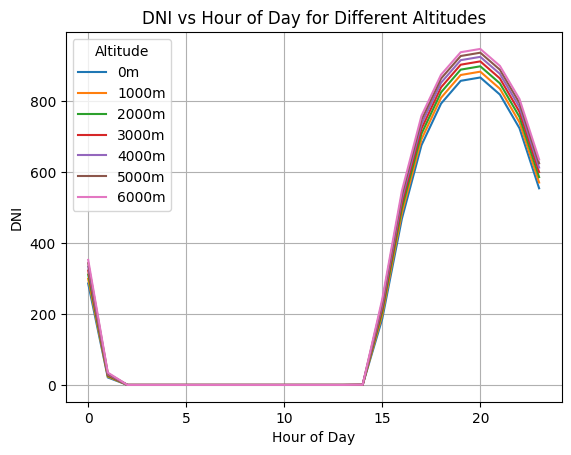

In [78]:
lat = 31.92
lon = -120.81
dtz = datetime(2022, 3, 20, 0, tzinfo=pytz.utc)

# Create a DataFrame to store irradiance data for all hours and altitudes
columns = ['Hour', 'Altitude', 'DNI']
rad_by_hour_and_alt = []

# Loop over altitudes from 0m to 6000m, in steps of 1000m
for alt in range(0, 7000, 1000):
    for hour in range(24):
        dthz = dtz + timedelta(hours=hour)
        irradiance = est_dni_from_py6s(lat, lon, alt, dthz)
        rad_by_hour_and_alt.append({'Hour': hour, 'Altitude': alt, 'DNI': irradiance})

df = pd.DataFrame(rad_by_hour_and_alt)
df.to_csv('/Users/timothydonohue/Downloads/solar_irradiance_ts.csv')

# Plotting
for altitude in range(0, 7000, 1000):
    subset = df[df['Altitude'] == altitude]
    plt.plot(subset['Hour'], subset['DNI'], label=f'{altitude}m')

plt.xlabel('Hour of Day')
plt.ylabel('DNI')
plt.title('DNI vs Hour of Day for Different Altitudes')
plt.legend(title='Altitude')
plt.grid(True)
plt.show()

In [5]:
def adjust_dni_for_altitude(lat, lon, dthz, interpolated_sfc_dni):

    # Get DNI at 0m and 5400m
    dni_at_0m = est_dni_from_py6s(lat, lon, 0, dthz)
    dni_at_5400m = est_dni_from_py6s(lat, lon, 5400, dthz)
    
    # If dni_at_0m is 0, set the adjustment factor to 1, so the original NASA DNI is used
    if dni_at_0m == 0:
        adjustment_factor = 1
    else:
        adjustment_factor = dni_at_5400m / dni_at_0m
        
    logging.debug(f"Altitude factor for {dthz} at {lat:.2f}, {lon:.2f} is {adjustment_factor:.3f}")
    
    # Calculate the adjusted DNI
    adjusted_dni = adjustment_factor * interpolated_sfc_dni
    logging.debug(f"Altitude-adjusted DNI at {lat:.2f}, {lon:.2f} at {dthz} is {adjusted_dni:.2f}")
    
    return adjusted_dni


In [13]:
def bilinear_interpolation(lat, lon, datetime_obj, data_dict, lat_range=(0, 60), lon_range=(-50, -20)):
    """
    Perform bilinear interpolation for a point (lat, lon) at a given datetime using a nested dictionary,
    adjust the DNI value based on altitude, and add both interpolated and adjusted values to the dictionary.
    lat - latitude, lon - longitude, datetime_obj - the specific datetime object for DNI values in UTC.
    lat_range - Tuple indicating the range of latitude values (default is (0, 60)).
    lon_range - Tuple indicating the range of longitude values (default is (-50, -20)).
    data_dict - nested dictionary structure {latitude: {longitude: {unix_timestamp: {'sfc_dni': value}}}}
    """
    unix_timestamp = int(datetime_obj.timestamp())
    print(lat, lon)

    # Slight perturbation inward for boundary points
    delta = 1e-6  # Small perturbation value
    if lat == lat_range[1]:
        lat -= delta  # Slightly decrease lat if it's on the upper boundary
        logging.debug(f"Adjusted latitude to {lat:.7f} for upper boundary")
    elif lat == lat_range[0]:
        lat += delta  # Slightly increase lat if it's on the lower boundary
        logging.debug(f"Adjusted latitude to {lat:.7f} for lower boundary")

    if lon == lon_range[0]:
        lon += delta  # Slightly increase lon if it's on the left boundary
        logging.debug(f"Adjusted longitude to {lon:.7f} for left boundary")
    elif lon == lon_range[1]:
        lon -= delta  # Slightly decrease lon if it's on the right boundary
        logging.debug(f"Adjusted longitude to {lon:.7f} for right boundary")

    if data_dict.get(lat) and data_dict[lat].get(lon) and data_dict[lat][lon].get(unix_timestamp):
        sfc_dni = data_dict[lat][lon][unix_timestamp].get('sfc_dni', float('nan'))
        alt_adj_dni = data_dict[lat][lon][unix_timestamp].get('alt_adj_dni', 
                                                              adjust_dni_for_altitude(lat, lon, datetime_obj, sfc_dni))
        logging.debug(f"DNI values (sfc: {sfc_dni:.2f}, alt-adj: {alt_adj_dni:.2f}) found for "
                      f"{lat:.2f}, {lon:.2f} at {datetime_obj}")
        return sfc_dni, alt_adj_dni

    # Identify the grid cell boundaries
    lat_lower = float(int(lat))
    lat_upper = lat_lower + 1
    lon_left = float(int(lon)) if lon > 0 else float(int(lon) - 1)
    lon_right = lon_left + 1
    logging.debug(f"Interpolation for {lat:.2f}, {lon:.2f} uses cell boundaries: lat [{lat_lower}, {lat_upper}], "
                f"lon [{lon_left}, {lon_right}]")

    values = {}
    for lat_bound in ('lower', 'upper'):
        for lon_bound in ('left', 'right'):
            current_lat = lat_lower if lat_bound == 'lower' else lat_upper
            current_lon = lon_left if lon_bound == 'left' else lon_right
    
            key_name = f"value_{lat_bound}_{lon_bound}"
            values[key_name] = data_dict.get(
                current_lat, {}
            ).get(
                current_lon, {}
            ).get(
                unix_timestamp, {'sfc_dni': float('nan')}
            )['sfc_dni']
            logging.debug(f"Retrieved {values[key_name]:.2f} DNI for {current_lat}, {current_lon} "
                          f"({lat_bound}-{lon_bound}) at {datetime_obj}")

    # Normalized distances
    lat_diff = lat - lat_lower
    lon_diff = lon - lon_left

    # Bilinear interpolation formula
    interpolated_sfc_dni = (values['value_lower_left'] * (1 - lat_diff) * (1 - lon_diff) +
                            values['value_lower_right'] * (1 - lat_diff) * lon_diff +
                            values['value_upper_left'] * lat_diff * (1 - lon_diff) +
                            values['value_upper_right'] * lat_diff * lon_diff)
    logging.debug(f"Interpolated DNI at {lat:.2f}, {lon:.2f} at {datetime_obj} is {interpolated_sfc_dni:.2f}")

    alt_adj_dni = adjust_dni_for_altitude(lat, lon, datetime_obj, interpolated_sfc_dni)

    # data_dict.setdefault(lat, {}).setdefault(lon, {})[unix_timestamp] = {'sfc_dni': interpolated_sfc_dni, 'alt_adj_dni': alt_adj_dni}

    return interpolated_sfc_dni, alt_adj_dni

# lat = 60.001
# lon = -50.00
# datetime_obj = datetime(2022, 3, 20, 0, 0, tzinfo=pytz.utc)
# 
# sfc_dni, alt_adj_dni = bilinear_interpolation(lat, lon, datetime_obj, data_dict)


In [9]:
time_step = 3  # Time step in hours
speed = 13  # Speed in m/s

# Constants
earth_circumference_km = 40075
degrees_per_latitude = earth_circumference_km / 360
travel_distance_km = speed * time_step * 3600 / 1000

lat_range = 61  # 0 to 60 degrees inclusive is 61 degrees
degrees_per_step_lat = travel_distance_km / degrees_per_latitude
logging.info(f"Vehicle traveling at {travel_distance_km} km/{time_step} hour(s) can move {degrees_per_step_lat:.4f} degrees latitudinally")
num_lat_steps = int(lat_range / degrees_per_step_lat)
logging.info(f"Domain defined by {lat_range} degrees of latitude discretized into {num_lat_steps} steps")

# Longitude steps for the range -20 to -50 at a representative latitude (e.g., 45 degrees)
# TODO - dynamically handle variation in longitudinal distance (but requires 3-d Q-table for each lat)
lon_range = 31 
representative_lat = 30
degrees_per_longitude_at_lat = np.cos(np.radians(representative_lat)) * degrees_per_latitude
degrees_per_step_lon = travel_distance_km / degrees_per_longitude_at_lat
logging.info(f"Vehicle traveling at {travel_distance_km} km/{time_step} hour(s) can move {degrees_per_step_lon:.4f} degrees longitudinally (representative latitude: {representative_lat})")
num_lon_steps = int(lon_range / degrees_per_step_lon)
logging.info(f"Domain defined by {lon_range} degrees of longitude discretized into {num_lon_steps} steps")

num_time_steps = int(24 / time_step * 365 / 4)
logging.info(f"{365 / 4} days discretized into {num_time_steps} time steps of {time_step} hours each")

num_actions = 9


2024-03-22 18:11:02,195 - INFO - Vehicle traveling at 140.4 km/3 hour(s) can move 1.2612 degrees latitudinally
2024-03-22 18:11:02,196 - INFO - Domain defined by 61 degrees of latitude discretized into 48 steps
2024-03-22 18:11:02,197 - INFO - Vehicle traveling at 140.4 km/3 hour(s) can move 1.4563 degrees longitudinally (representative latitude: 30)
2024-03-22 18:11:02,198 - INFO - Domain defined by 31 degrees of longitude discretized into 21 steps
2024-03-22 18:11:02,199 - INFO - 91.25 days discretized into 730 time steps of 3 hours each


In [10]:
def take_action(state, action, num_lat_steps, num_lon_steps, num_time_steps):
    lat_index, lon_index, time_index = state
    
    action_effects = {
        0: (1, 0),  # 'N'
        1: (1, 1),  # 'NE'
        2: (0, 1),  # 'E'
        3: (-1, 1), # 'SE'
        4: (-1, 0), # 'S'
        5: (-1, -1),# 'SW'
        6: (0, -1), # 'W'
        7: (1, -1), # 'NW'
        8: (0, 0),  # 'STAY'
    }
    logging.debug(f"Vehicle moves {action_effects[action]} from {lat_index}, {lon_index}")
    
    lat_change, lon_change = action_effects[action]
    
    new_lat_index = max(0, min(num_lat_steps - 1, lat_index + lat_change))
    new_lon_index = max(0, min(num_lon_steps - 1, lon_index + lon_change))
    
    new_time_index = min(time_index + 1, num_time_steps - 1)
    logging.debug(f"State at time {new_time_index} becomes {new_lat_index}, {new_lon_index}")

    return new_lat_index, new_lon_index, new_time_index


def convert_state_to_sensible_values(state, num_lat_steps, num_lon_steps, time_step,
                                     lat_range=(0, 60), lon_range=(-50, -20)):
    lat_index, lon_index, time_index = state

    # Adjust geo_lat calculation based on the provided lat_range
    geo_lat = ((lat_index / (num_lat_steps - 1)) * abs(lat_range[0] - lat_range[1])) + lat_range[0]

    # Adjust geo_lon calculation based on the provided lon_range
    # Using abs() to ensure the correct step calculation for negative ranges
    geo_lon = ((lon_index / (num_lon_steps - 1)) * abs(lon_range[0] - lon_range[1])) + lon_range[0]

    hours = time_index * time_step
    dthz = datetime(2022, 3, 20, tzinfo=pytz.utc) + timedelta(hours=hours)
    
    dthl = dthz
    if logging.getLogger().getEffectiveLevel() == logging.DEBUG:
        tf = TimezoneFinder()
        time_zone_str = tf.timezone_at(lat=geo_lat, lng=geo_lon)
        
        if time_zone_str:
            time_zone = pytz.timezone(time_zone_str)
            dthl = dthz.astimezone(time_zone)
    else:
        # Calculate local time adjustment based on longitude
        local_time_offset = timedelta(hours=geo_lon / 15)
        dthl = dthz + local_time_offset

    return geo_lat, geo_lon, dthz, dthl



60.0 -50.0 2022-05-05 00:00:00+00:00 2022-05-04 21:00:00-03:00


In [14]:
def take_action_and_get_reward(state, action, altitude_adjusted=True):
    new_state = take_action(state, action, num_lat_steps, num_lon_steps, num_time_steps)
    geo_lat, geo_lon, dthz, dthl = convert_state_to_sensible_values(new_state, num_lat_steps,
                                                                    num_lon_steps, time_step)
    geo_coords = (geo_lat, geo_lon)
    
    sfc_dni, alt_adj_dni = bilinear_interpolation(geo_lat, geo_lon, dthz, data_dict)  
    reward = alt_adj_dni if altitude_adjusted else sfc_dni
    logging.debug(f"Vehicle moved to {geo_lat:.2f}, {geo_lon:.2f} at {dthz} ({dthl}) with reward {reward:.2f} w/m^2")

    return new_state, reward, geo_coords, dthz

state = (46, 0, 367)
action = 0
new_state, reward, geo_coords, dthz = take_action_and_get_reward(state, action)

2024-03-22 18:49:45,801 - DEBUG - Vehicle moves (1, 0) from 46, 0
2024-03-22 18:49:45,802 - DEBUG - State at time 368 becomes 47, 0
2024-03-22 18:49:46,085 - DEBUG - Adjusted latitude to 59.9999990 for upper boundary
2024-03-22 18:49:46,086 - DEBUG - Adjusted longitude to -49.9999990 for left boundary
2024-03-22 18:49:46,086 - DEBUG - Interpolation for 60.00, -50.00 uses cell boundaries: lat [59.0, 60.0], lon [-50.0, -49.0]
2024-03-22 18:49:46,086 - DEBUG - Retrieved 0.00 DNI for 59.0, -50.0 (lower-left) at 2022-05-05 00:00:00+00:00
2024-03-22 18:49:46,087 - DEBUG - Retrieved 0.00 DNI for 59.0, -49.0 (lower-right) at 2022-05-05 00:00:00+00:00
2024-03-22 18:49:46,087 - DEBUG - Retrieved 0.00 DNI for 60.0, -50.0 (upper-left) at 2022-05-05 00:00:00+00:00
2024-03-22 18:49:46,087 - DEBUG - Retrieved 0.00 DNI for 60.0, -49.0 (upper-right) at 2022-05-05 00:00:00+00:00
2024-03-22 18:49:46,087 - DEBUG - Interpolated DNI at 60.00, -50.00 at 2022-05-05 00:00:00+00:00 is 0.00
2024-03-22 18:49:46,0

60.0 -50.0


#### Calculate starting point

In [4]:
df = df[(df['YEAR'] == 2022) & (df['MO'] == 3) & (df['DY'] == 20)]
df['coords'] = df.apply(lambda row: (row['lat'], row['lon']), axis=1)
df.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DNI,lat,lon,coords
0,2022,3,20,0,0.0,0,-20,"(0.0, -20.0)"
1,2022,3,20,1,0.0,0,-20,"(0.0, -20.0)"
2,2022,3,20,2,0.0,0,-20,"(0.0, -20.0)"
3,2022,3,20,3,0.0,0,-20,"(0.0, -20.0)"
4,2022,3,20,4,0.0,0,-20,"(0.0, -20.0)"


In [12]:
df.groupby('coords')['ALLSKY_SFC_SW_DNI'].mean().reset_index().sort_values('ALLSKY_SFC_SW_DNI', ascending=False)

,coords,ALLSKY_SFC_SW_DNI
874,"(28.0, -44.0)",382.176667
839,"(27.0, -48.0)",375.721667
873,"(28.0, -45.0)",374.184583
843,"(27.0, -44.0)",372.465000
875,"(28.0, -43.0)",372.437083
...,...,...
1687,"(54.0, -37.0)",16.238750
1688,"(54.0, -36.0)",15.941667
1689,"(54.0, -35.0)",15.941667
1720,"(55.0, -35.0)",13.294167


In [10]:
def get_state_from_coordinates(lat, lon, num_lat_steps, num_lon_steps, lat_range_start=0, lon_range_end=-50):
    """
    Convert latitude and longitude to their respective indices in the grid.
    
    :param lat: Latitude to convert.
    :param lon: Longitude to convert.
    :param num_lat_steps: Total number of latitude steps in the grid.
    :param num_lon_steps: Total number of longitude steps in the grid.
    :param lat_range_start: Starting latitude of the grid (0).
    :param lon_range_end: Ending longitude of the grid (-50).
    :return: Indices corresponding to the latitude and longitude.
    """
    # Ensure that lat and lon are within the allowed range
    lat = max(lat_range_start, min(lat_range_start + 60, lat))
    lon = max(lon_range_end, min(-20, lon))

    # Calculate the step size for each latitude and longitude
    lat_step_size = 60 / num_lat_steps
    lon_step_size = abs(lon_range_end + 20) / num_lon_steps  # The range should be positive

    # Calculate the indices
    lat_index = int((lat - lat_range_start) / lat_step_size)
    lon_index = int((lon - lon_range_end) / lon_step_size)  # Adjust based on the end of the range

    return lat_index, lon_index

lat, lon = 28.0, -44.0
lat_index, lon_index = get_state_from_coordinates(lat, lon, num_lat_steps, num_lon_steps, lat_range_start=0, lon_range_end=-50)

print(f"Latitude index: {lat_index}, Longitude index: {lon_index}")


Latitude index: 22, Longitude index: 4


#### Run Q-learning

In [10]:
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPISODES = 4000

actual_altitude = 5400

epsilon = 1.0  # Initial epsilon
epsilon_min = 0.01  # Minimum epsilon value
epsilon_decay = 0.995  # Decay factor

q_table = np.zeros((num_lat_steps, num_lon_steps, num_time_steps, num_actions))
logging.info(f"Q-table created with shape: {q_table.shape}")

initial_lat_index = 22
initial_lon_index = 4
# TODO - allow agent to learn optimal starting lat/lon

eval_metrics = {
    'episode_rewards': [],
    'steps': [],
}

for episode in range(EPISODES):
    total_reward = 0
    episode_details = []

    state = (initial_lat_index, initial_lon_index, 0)
    init_geo_lat, init_geo_lon, init_dtmz, init_dthl = convert_state_to_sensible_values(state, num_lat_steps, num_lon_steps, time_step)
    
    if episode % 10 == 0 or episode == 0:
        logging.info(f"Episode {episode} - Epsilon: {epsilon}")
    logging.debug(f"Ep. {episode} initialized at {init_dtmz} ({init_dthl}), {init_geo_lat:.2f}, {init_geo_lon:.2f} (index state: {state}); epsilon: {epsilon}")
    
    for step in range(num_time_steps):
        if step == num_time_steps - 1:  # Skip taking action at the last step
            break
            
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_actions - 1)  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit
        
        new_state, reward, geo_coords, dthz = take_action_and_get_reward(state, action)
        total_reward += reward
        
        # Save step details
        step_details = {
            'step': step,
            'dthz': dthz.strftime('%Y-%m-%d %H:%M'),
            'coords': geo_coords,
            'reward': reward,
        }
        episode_details.append(step_details)

        # Q-table update
        best_future_q = np.max(q_table[new_state])
        q_table[state + (action,)] = q_table[state + (action,)] + LEARNING_RATE * (reward + DISCOUNT_FACTOR * best_future_q - q_table[state + (action,)])
        state = new_state
    
    average_reward = total_reward / num_time_steps 
    eval_metrics['episode_rewards'].append(average_reward)
    eval_metrics['steps'].append(episode_details)

    if episode % 10 == 0:
        logging.info(f"Episode {episode} - average reward: {average_reward:.2f}")
    logging.debug(f"Ep. {episode} ended with average reward: {average_reward:.2f}")
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)


2024-03-18 13:25:18,081 - INFO - Q-table created with shape: (48, 21, 730, 9)
2024-03-18 13:25:18,082 - INFO - Episode 0 - Epsilon: 1.0
2024-03-18 13:25:36,925 - INFO - Episode 0 - average reward: 186.20
2024-03-18 13:28:58,755 - INFO - Episode 10 - Epsilon: 0.9511101304657719
2024-03-18 13:29:19,747 - INFO - Episode 10 - average reward: 191.05
2024-03-18 13:32:50,779 - INFO - Episode 20 - Epsilon: 0.9046104802746175
2024-03-18 13:33:13,448 - INFO - Episode 20 - average reward: 173.62
2024-03-18 13:36:44,412 - INFO - Episode 30 - Epsilon: 0.8603841919146962
2024-03-18 13:37:07,367 - INFO - Episode 30 - average reward: 124.67
2024-03-18 13:40:28,555 - INFO - Episode 40 - Epsilon: 0.8183201210226743
2024-03-18 13:40:51,095 - INFO - Episode 40 - average reward: 112.15
2024-03-18 13:44:02,915 - INFO - Episode 50 - Epsilon: 0.778312557068642
2024-03-18 13:44:23,535 - INFO - Episode 50 - average reward: 147.71
2024-03-18 13:47:35,608 - INFO - Episode 60 - Epsilon: 0.7402609576967045
2024-03-

In [11]:
# save q-table
np.save('/Users/timothydonohue/Documents/Data/q_table_031920221803.npy', q_table)

In [11]:
eval_metrics['episode_rewards']

[162.31896048407592,
 193.41688731939297,
 229.2868497002959,
 247.1270831423277,
 258.62813190589236,
 169.54436533190054,
 219.41244040574793,
 135.0261689019784,
 156.09837244587322,
 122.24939589263721]

In [16]:
test_eps = 10
test_time = 3 + (33.782/60) # 3m 33.782s
test_min_per_ep = test_time / test_eps

target_eps = 4000
est_run_hours = test_min_per_ep * target_eps / 60
est_run_hours

23.753555555555554

In [2]:
q_table = np.load('/Users/timothydonohue/Documents/Data/q_table_031920221803.npy')

In [13]:
initial_lat_index = 22
initial_lon_index = 4
num_time_steps = int(24 / time_step * 365 / 4)

# Initialize the current state
current_state = (initial_lat_index, initial_lon_index, 0)
optimal_path = [current_state]

# Extract the optimal path
for time_step in range(num_time_steps - 1):  # Subtract 1 since we don't need to take action at the last time step
    current_lat, current_lon, current_time = current_state
    # Select the action with the highest Q-value for the current state
    action = np.argmax(q_table[current_lat, current_lon, current_time, :])
    # Determine the next state based on the chosen action
    next_state = take_action(current_state, action, num_lat_steps, num_lon_steps, num_time_steps)
    # Append the next state to the optimal path
    optimal_path.append(next_state)
    # Update the current state
    current_state = next_state

    if current_state[2] == num_time_steps - 1:  # Break if we reach the last time step
        break

# Now, optimal_path contains the sequence of states (lat_index, lon_index, time_step) for the optimal path


In [14]:
optimal_path[:5]

[(22, 4, 0), (23, 4, 1), (23, 3, 2), (22, 2, 3), (22, 1, 4)]

In [32]:
data = []

for state in optimal_path:
    action = np.argmax(q_table[state])
    q_value = q_table[state + (action,)]

    # Convert state indices to geographic coordinates and time
    geo_lat, geo_lon, dthz, dthl = convert_state_to_sensible_values(state, num_lat_steps, num_lon_steps, time_step)

    # Get sfc_dni and alt_adj_dni using bilinear interpolation
    sfc_dni, alt_adj_dni = bilinear_interpolation(geo_lat, geo_lon, dthz, data_dict)

    # Append data for this step
    data.append({
        'dthz': dthz,
        'dthl': dthl,
        'lat': geo_lat,
        'lon': geo_lon,
        'sfc_dni': sfc_dni,
        'alt_adj_dni': alt_adj_dni,
        'q_value': q_value
    })

# Create the DataFrame
df = pd.DataFrame(data)
df.index.name = 'step'

In [33]:
df.head()

,dthz,dthl,lat,lon,sfc_dni,alt_adj_dni,q_value
step,,,,,,,
0,2022-03-20 00:00:00+00:00,2022-03-19 21:04:00+00:00,28.085106,-44.0,0.000000,0.000000,6406.664346
1,2022-03-20 03:00:00+00:00,2022-03-20 00:04:00+00:00,29.361702,-44.0,0.000000,0.000000,6743.857233
2,2022-03-20 06:00:00+00:00,2022-03-20 02:58:00+00:00,29.361702,-45.5,0.000000,0.000000,7098.797115
3,2022-03-20 09:00:00+00:00,2022-03-20 05:52:00+00:00,28.085106,-47.0,221.359149,885.436596,6540.379522
4,2022-03-20 12:00:00+00:00,2022-03-20 08:46:00+00:00,28.085106,-48.5,826.255638,920.108050,5916.075263


In [34]:
df.tail()

,dthz,dthl,lat,lon,sfc_dni,alt_adj_dni,q_value
step,,,,,,,
725,2022-06-18 15:00:00+00:00,2022-06-18 11:40:00+00:00,60.000000,-50.0,295.049799,323.223475,231.530687
726,2022-06-18 18:00:00+00:00,2022-06-18 14:40:00+00:00,60.000000,-50.0,99.959959,111.759641,126.074785
727,2022-06-18 21:00:00+00:00,2022-06-18 17:40:00+00:00,58.723404,-50.0,95.526809,119.899791,6.499994
728,2022-06-19 00:00:00+00:00,2022-06-18 20:40:00+00:00,60.000000,-50.0,6.499994,6.499994,0.000000
729,2022-06-19 03:00:00+00:00,2022-06-18 23:40:00+00:00,60.000000,-50.0,0.000000,0.000000,0.000000


In [35]:
df['sfc_dni'].describe()

count    730.000000
mean     178.430352
std      215.478385
min        0.000000
25%        0.000000
50%       94.795399
75%      274.410053
max      940.859629
Name: sfc_dni, dtype: float64

In [36]:
df['alt_adj_dni'].describe()

count     730.000000
mean      217.078096
std       250.175219
min         0.000000
25%         0.000000
50%       122.694052
75%       337.720515
max      1067.070876
Name: alt_adj_dni, dtype: float64

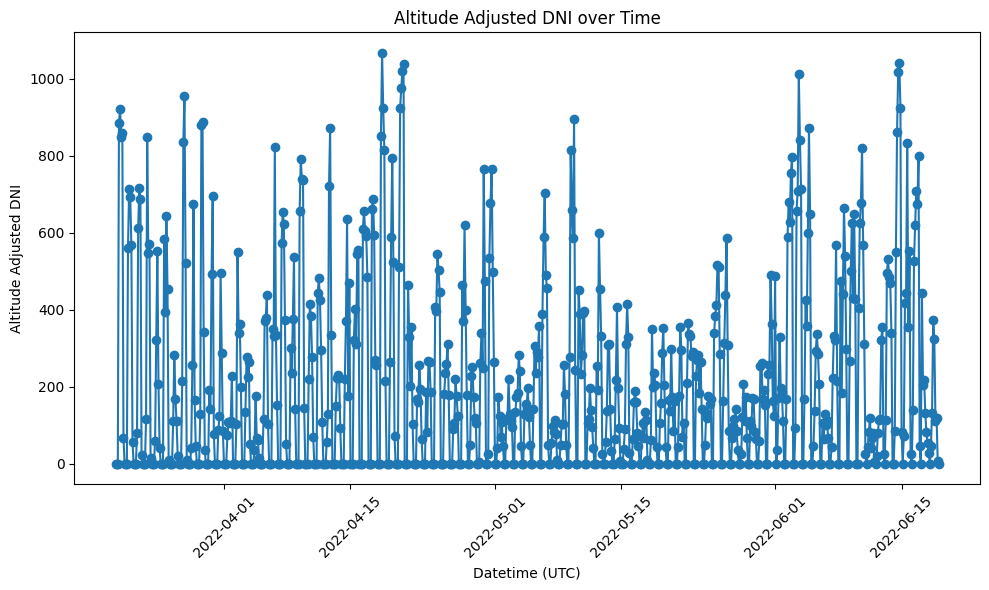

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df['dthz'], df['alt_adj_dni'], marker='o', linestyle='-')
plt.title('Altitude Adjusted DNI over Time')
plt.xlabel('Datetime (UTC)')
plt.ylabel('Altitude Adjusted DNI')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [41]:
nasa_power_df = pd.read_csv('/Users/timothydonohue/Documents/Data/nasa_power_data.csv')
nasa_power_df['coords'] = nasa_power_df.apply(lambda row: (row['lat'], row['lon']), axis=1)

nasa_power_df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}, inplace=True)
nasa_power_df['timestamp'] = pd.to_datetime(nasa_power_df[['year', 'month', 'day', 'hour']], utc=True)

nasa_power_df = nasa_power_df.drop(['year', 'month', 'day', 'hour'], axis=1)

# convert lat and lon columns to float
nasa_power_df['lat'] = nasa_power_df['lat'].astype(float)
nasa_power_df['lon'] = nasa_power_df['lon'].astype(float)

nasa_power_df.rename(columns={'ALLSKY_SFC_SW_DNI': 'sfc_dni'}, inplace=True)
nasa_power_df.head()

,sfc_dni,lat,lon,coords,timestamp
0,0.0,0.0,-20.0,"(0.0, -20.0)",2022-03-20 00:00:00+00:00
1,0.0,0.0,-20.0,"(0.0, -20.0)",2022-03-20 01:00:00+00:00
2,0.0,0.0,-20.0,"(0.0, -20.0)",2022-03-20 02:00:00+00:00
3,0.0,0.0,-20.0,"(0.0, -20.0)",2022-03-20 03:00:00+00:00
4,0.0,0.0,-20.0,"(0.0, -20.0)",2022-03-20 04:00:00+00:00


In [39]:
nasa_power_df['ALLSKY_SFC_SW_DNI'].describe()

count    8.577576e+06
mean     1.792235e+02
std      2.476678e+02
min     -9.990000e+02
25%      0.000000e+00
50%      5.066000e+01
75%      2.900300e+02
max      1.035940e+03
Name: ALLSKY_SFC_SW_DNI, dtype: float64

In [45]:
nasa_power_df['date'] = nasa_power_df['timestamp'].dt.date

# Grouping by date and getting the max sfc_dni for each day
avg_daily_dni = nasa_power_df.groupby(['date', 'coords'])['sfc_dni'].mean().reset_index().sort_values('sfc_dni', ascending=False)

In [48]:
max_daily_dni = avg_daily_dni.groupby('date')['sfc_dni'].max().reset_index()
max_daily_dni['sfc_dni'].describe()

count    189.000000
mean     440.861371
std       38.784639
min      348.441667
25%      417.257500
50%      440.717917
75%      460.400833
max      610.606667
Name: sfc_dni, dtype: float64

In [18]:
directory_path = "/Users/timothydonohue/Documents/Data/nsrdbv3_dni/Monthly DNI"

# List to store the maximum DNI and coordinates for each month
max_dni_per_month = []

for filename in os.listdir(directory_path):
    if filename.endswith(".tif"):
        # Construct the full file path
        file_path = os.path.join(directory_path, filename)
        
        # Open the raster file
        with rasterio.open(file_path) as src:
            # Read the data
            data = src.read(1)
            
            # Find the maximum value and its index
            max_value = data.max()
            max_index = data.argmax()
            max_row, max_col = divmod(max_index, data.shape[1])

            # Convert the row, col indices to spatial coordinates
            max_coords = src.xy(max_row, max_col)
            
            # Append the results to the list
            max_dni_per_month.append({
                'file': filename,
                'max_value': max_value,
                'max_coords': max_coords
            })
            
max_dni_per_month

2024-03-24 13:15:45,624 - DEBUG - Entering env context: <rasterio.env.Env object at 0x3c956b0d0>
2024-03-24 13:15:45,633 - DEBUG - Starting outermost env
2024-03-24 13:15:45,636 - DEBUG - No GDAL environment exists
2024-03-24 13:15:45,638 - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x11380fac0> created
2024-03-24 13:15:45,664 - DEBUG - Installing FilePath filesystem handler plugin...
2024-03-24 13:15:45,665 - DEBUG - GDAL data found in package: path='/Users/timothydonohue/opt/anaconda3/envs/13oct_conda_update/lib/python3.9/site-packages/rasterio/gdal_data'.
2024-03-24 13:15:45,665 - DEBUG - PROJ data found in package: path='/Users/timothydonohue/opt/anaconda3/envs/13oct_conda_update/lib/python3.9/site-packages/rasterio/proj_data'.
2024-03-24 13:15:45,666 - DEBUG - Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x11380fac0>.
2024-03-24 13:15:45,667 - DEBUG - Entered env context: <rasterio.env.Env object at 0x3c956b0d0>
2024-03-24 13:15:45,668 - DEBUG - Sharin

[{'file': 'dni_apr.tif',
  'max_value': 431.99203216374264,
  'max_coords': (-115.38, 30.970000000000002)},
 {'file': 'dni_mar.tif',
  'max_value': 420.44344227504246,
  'max_coords': (-67.89999999999999, -20.43)},
 {'file': 'dni_dec.tif',
  'max_value': 465.10770373514436,
  'max_coords': (-68.3, -20.470000000000006)},
 {'file': 'dni_feb.tif',
  'max_value': 414.18597274436087,
  'max_coords': (-67.58, -20.389999999999993)},
 {'file': 'dni_may.tif',
  'max_value': 463.259656196944,
  'max_coords': (-115.42, 30.970000000000002)},
 {'file': 'dni_aug.tif',
  'max_value': 446.0972340124505,
  'max_coords': (-122.22, 41.41)},
 {'file': 'dni_sep.tif',
  'max_value': 469.05847953216363,
  'max_coords': (-68.46, -20.949999999999996)},
 {'file': 'dni_oct.tif',
  'max_value': 490.9510469722694,
  'max_coords': (-69.1, -19.509999999999998)},
 {'file': 'dni_jul.tif',
  'max_value': 483.0377051499718,
  'max_coords': (-122.22, 41.41)},
 {'file': 'dni_jun.tif',
  'max_value': 477.88077485380126,
  

In [21]:
# calculate average max_value across files
monthly_max_values = [month['max_value'] for month in max_dni_per_month]
print(monthly_max_values)
avg_max_value = np.mean(monthly_max_values)
avg_max_value

[431.99203216374264, 420.44344227504246, 465.10770373514436, 414.18597274436087, 463.259656196944, 446.0972340124505, 469.05847953216363, 490.9510469722694, 483.0377051499718, 477.88077485380126, 514.8592470760234, 423.8156479909451]


458.3907452252383

In [14]:
api_key = os.getenv('GOOGLE_MAPS_KEY')

def add_elevation(lat, lon):
    # Round the latitude and longitude to 4 decimal places
    lat = round(lat, 7)
    lon = round(lon, 7)

    url = f"https://maps.googleapis.com/maps/api/elevation/json?locations={lat}%2C{lon}&key={api_key}"
    response = requests.get(url)
    data = response.json()
    elevation = data['results'][0]['elevation']
    
    return elevation

for month in max_dni_per_month:
    lon, lat = month['max_coords']
    month['elevation'] = add_elevation(lat, lon)
    
max_dni_per_month

[{'file': 'dni_apr.tif',
  'max_value': 431.99203216374264,
  'max_coords': (-115.38, 30.970000000000002),
  'elevation': 2102.3466796875},
 {'file': 'dni_mar.tif',
  'max_value': 420.44344227504246,
  'max_coords': (-67.89999999999999, -20.43),
  'elevation': 3659.343994140625},
 {'file': 'dni_dec.tif',
  'max_value': 465.10770373514436,
  'max_coords': (-68.3, -20.470000000000006),
  'elevation': 4355.240234375},
 {'file': 'dni_feb.tif',
  'max_value': 414.18597274436087,
  'max_coords': (-67.58, -20.389999999999993),
  'elevation': 3659.418701171875},
 {'file': 'dni_may.tif',
  'max_value': 463.259656196944,
  'max_coords': (-115.42, 30.970000000000002),
  'elevation': 2635.36328125},
 {'file': 'dni_aug.tif',
  'max_value': 446.0972340124505,
  'max_coords': (-122.22, 41.41),
  'elevation': 3697.95849609375},
 {'file': 'dni_sep.tif',
  'max_value': 469.05847953216363,
  'max_coords': (-68.46, -20.949999999999996),
  'elevation': 5195.7412109375},
 {'file': 'dni_oct.tif',
  'max_valu